
# ISIC 2024 - Skin Cancer Detection with 3D-TBP

Nicholas Kurtansky, Veronica Rotemberg, Maura Gillis, Kivanc Kose, Walter Reade, Ashley Chow. (2024). ISIC 2024 - Skin Cancer Detection with 3D-TBP. Kaggle. 

https://kaggle.com/competitions/isic-2024-challenge

Currently heavily in development.

In [1]:
import os
import os.path as path
import gc
import cv2
import math
import copy
import time
import random
import glob
import warnings

import h5py

from matplotlib import pyplot as plt
import seaborn as sns

from functools import partial

import numpy as np
import pandas as pd

# Pytorch
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F
# from torch.optim import lr_scheduler
# from torch.utils.data import Dataset, DataLoader
# from torch.cuda import amp
# import torchvision
# from torcheval.metrics.functional import binary_auroc

# Tensorflow 
import tensorflow as tf

# Sklearn 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold 

# import timm

# Albumentations
import albumentations as A
# from albumentations.pytorch import ToTensorV2

2024-10-16 17:47:37.741024: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 17:47:37.756953: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-16 17:47:37.761984: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-16 17:47:37.774130: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-16 17:47:38.419632: W tensorflow/compiler/tf2

In [2]:
env_cfg = {
    "seed": 42,
    # "device": nn.device("cuda:0" if nn.cuda. else "cpu"),
    "device" : "GPU" if tf.config.list_physical_devices('GPU') else "CPU",
    "verbosity": '3',
}
CONFIG = {
    "seed": 42,
    "epochs": 50,
    "img_size": 384,
    "model_name": "",
    "checkpoint_path" : "/ISIC2024_SkinCancerDetection/saved_models",
    "train_batch_size": 32,
    
    "valid_batch_size": 64,
    "learning_rate": 1e-4,
    
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 1e-6,
    "T_max": 500,
}

print(f"Using device: {env_cfg['device']}")

Using device: GPU


I0000 00:00:1729093659.320117    7544 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729093659.360745    7544 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729093659.362283    7544 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [3]:
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = env_cfg["verbosity"]
os.environ['TF_CPP_MIN_LOG_LEVEL'] = env_cfg["verbosity"]

In [4]:
# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".XX"
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

tf.debugging.set_log_device_placement(False)

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [83]:
def set_seed(seed=42):

    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    
    tf.random.set_seed(seed)
    
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)
    
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
  
    # When running on the CuDNN backend, two further options must be set
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False
    
set_seed()

In [7]:
# https://www.kaggle.com/code/motono0223/isic-pytorch-training-baseline-image-only#Training-Function

ROOT_DIR = path.normpath("./data/")
TRAIN_DIR = f'{ROOT_DIR}/train-image/image/'

train_images = sorted(glob.glob(f"{TRAIN_DIR}/*.jpg"))
print(TRAIN_DIR)
print("Number of train_images:", len(train_images))

data
data/train-image/image/
Number of train_images: 401059


In [8]:
train_images[:5]

['data/train-image/image/ISIC_0015670.jpg',
 'data/train-image/image/ISIC_0015845.jpg',
 'data/train-image/image/ISIC_0015864.jpg',
 'data/train-image/image/ISIC_0015902.jpg',
 'data/train-image/image/ISIC_0024200.jpg']

data/train-image/image//ISIC_0015864.jpg


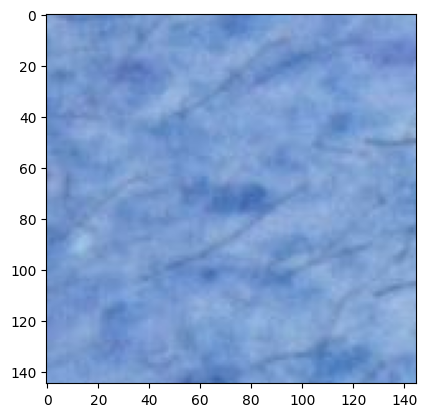

In [9]:
def get_train_file_path(image_id):
    return f"{TRAIN_DIR}/{image_id}.jpg"

print(get_train_file_path("ISIC_0015864"))
img = cv2.imread(get_train_file_path("ISIC_0015864"))

plt.imshow(img)

In [50]:
df = pd.read_csv(f"{ROOT_DIR}/train-metadata.csv")

print(df.shape)

df_positive = df[df["target"] == 1].reset_index(drop=True)
df_negative = df[df["target"] == 0].reset_index(drop=True)

print("Unique patients:",  df["patient_id"].unique().shape)

print("Pos:", df_positive.shape)
print("Unique positive patients:",  df_po
      sitive["patient_id"].unique().shape)

print("NEg:", df_negative.shape)
print("Unique neg patients:",  df_negative["patient_id"].unique().shape)

(401059, 55)
Unique patients: (1042,)
Pos: (393, 55)
Unique positive patients: (259,)
NEg: (400666, 55)
Unique neg patients: (1041,)


In [ ]:
# Potential imbalanced dataset
# df = pd.concat([df_positive, df_negative.iloc[:df_positive.shape[0]*20, :]])  # positive:negative = 1:20
# print("filtered", df.shape, df.target.sum(), df["patient_id"].unique().shape)

df['file_path'] = df['isic_id'].apply(get_train_file_path)
# df = df[ df["file_path"].isin(train_images) ].reset_index(drop=True)
df.head()

In [11]:
# Data exploration ...

print("Number of unique patients: ", df["patient_id"].nunique())

Number of unique patients:  1042


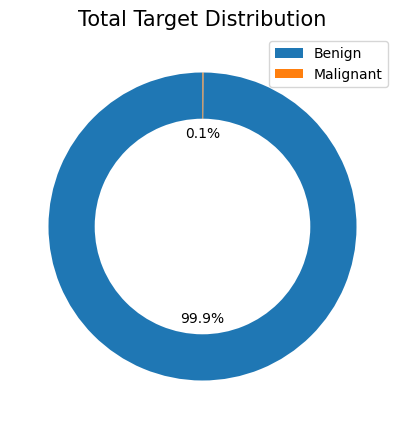

(400666, 55) (393, 55)


In [12]:
name = ['Benign', 'Malignant']

plt.figure(figsize = (5, 5))
plt.pie(df.target.value_counts(normalize = True), autopct = '%1.1f%%', startangle = 90, wedgeprops = dict(width = 0.3), 
        labeldistance = 1.2, radius = 1)
plt.title(f'Total Target Distribution', color = 'black', fontsize = 15)
plt.legend(name,)

plt.show()

print(df_negative.shape, df_positive.shape)

In [13]:
missing_values_count = df.isnull().sum()
print(sorted(missing_values_count, reverse=True))

[401058, 401006, 400996, 400508, 399994, 399991, 379001, 11517, 5756, 2798, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [14]:
data_transforms = {
    "train": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.RandomRotate90(p=0.5),
        A.Flip(p=0.5),
        A.Downscale(p=0.25),
        A.ShiftScaleRotate(shift_limit=0.1, 
                           scale_limit=0.15, 
                           rotate_limit=60, 
                           p=0.5),
        A.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
        A.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        # ToTensorV2()
    ], p=1.),
    
    "valid": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        # ToTensorV2()
    ], p=1.)
}


In [15]:
def aug_fn(image, img_size, train):
    data = {"image":image}
    aug_data = data_transforms(**data["train" if train else "valid"])
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img/255.0, tf.float32)
    return tf.image.resize(aug_img, size=[img_size, img_size])

In [16]:
def process_data(image, img_size):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
    return aug_img

In [17]:
# Loading images, too slow
# x_train = []
# y_train = []
# with h5py.File('ISIC2024_SkinCancerDetection/data/train-image.hdf5', 'r') as f:
#        keys = list(f.keys())
#        for key in keys:
#            data = f[key]
#            x_train.append(data[()].decode('latin-1'))
#            
#            # x_train.append(f[key][:]) 
#            y_train.append(key)
#               
# print(len(x_train), len(y_train))
# print(x_train[:5], y_train[:5])

In [18]:
training_validation_hdf5 = h5py.File(f"{ROOT_DIR}/train-image.hdf5", 'r')
testing_hdf5 = h5py.File(f"{ROOT_DIR}/test-image.hdf5", 'r')

Byte String: b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00'....
Image: [[[180 146 134]
  [180 146 134]
  [180 146 134]
  ...
  [191 153 144]
  [190 152 143]
  [189 152 143]]

 [[184 150 138]
  [183 149 137]
  [183 149 137]
  ...
  [189 151 142]
  [189 151 142]
  [187 150 141]]

 [[191 155 143]
  [190 154 142]
  [189 153 141]
  ...
  [184 146 137]
  [183 145 136]
  [183 145 136]]

 ...

 [[191 150 144]
  [186 145 139]
  [179 138 132]
  ...
  [174 130 117]
  [175 131 118]
  [176 132 119]]

 [[190 149 143]
  [185 144 138]
  [179 139 131]
  ...
  [174 130 117]
  [175 131 118]
  [176 132 119]]

 [[188 147 141]
  [184 143 137]
  [178 138 130]
  ...
  [174 130 117]
  [174 130 117]
  [175 131 118]]]


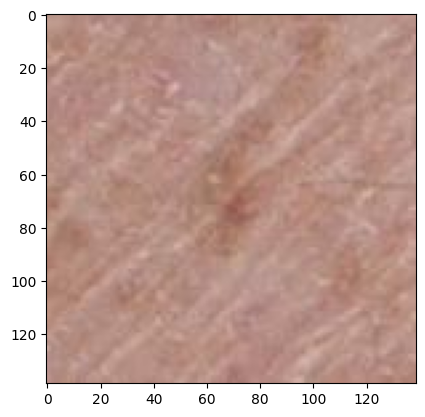

In [19]:
isic_id = df.isic_id.iloc[0]

byte_string = training_validation_hdf5[isic_id][()]
print(f"Byte String: {byte_string[:20]}....")

nparr = np.frombuffer(byte_string, np.uint8)

image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)[...,::-1] # reverse last axis for bgr -> rgb
print(f"Image: {image}")
plt.imshow(image);

In [20]:
data_ids = df.isic_id.values

images = [None]*len(data_ids)
for i, isic_id in enumerate(data_ids):
    images[i] = training_validation_hdf5[isic_id][()]

print(f"Loaded {len(images)} images.")
print(f"First image shape: {cv2.imdecode(np.frombuffer(images[0], np.uint8), cv2.IMREAD_COLOR).shape}.")

Loaded 401059 images.
First image shape: (139, 139, 3).


In [21]:
# hist = [cv2.calcHist([cv2.imdecode(np.frombuffer(img, np.uint8), cv2.IMREAD_COLOR)], [0], None, [256], [0, 256]) for img in images]
# hist = np.array(hist).squeeze()
# plt.plot(hist[0], label="Blue")

In [22]:
# Based on https://www.kaggle.com/code/awsaf49/isic2024-kerascv-starter

def decoder(only_image=False, with_labels=True, target_size=(256, 256)):
    
    def decode_only_image(file_bytes, label):
        
        image = tf.io.decode_jpeg(file_bytes)
        
        image = tf.image.resize(image, size=target_size, method="area")
        
        image = tf.cast(image, tf.float32)
        image /= 255.0
  
        image = tf.reshape(image, [*target_size, 3])
        
        return image, label
    
    def decode_image(inp):
        
        file_bytes = inp["images"]
        image = tf.io.decode_jpeg(file_bytes)
        
        image = tf.image.resize(image, size=target_size, method="area")
        
        image = tf.cast(image, tf.float32)
        image /= 255.0
  
        image = tf.reshape(image, [*target_size, 3])
        
        inp["images"] = image
        return inp
    
    
    def decode_label(label, num_classes):
        label = tf.cast(label, tf.float32)
        label = tf.reshape(label, [num_classes])
        return label
    
  
    def decode_with_labels(inp, label=None):
        inp = decode_image(inp)
        label = decode_label(label, 1)
        return inp, label
    
    if only_image:
        return decode_only_image
    return decode_with_labels if with_labels else decode_image

multi_decoder = decoder(with_labels=False, target_size=(CONFIG["img_size"], CONFIG["img_size"]))
image_decoder = decoder(only_image=True, with_labels=False, target_size=(CONFIG["img_size"], CONFIG["img_size"]))

In [23]:
# Too slow
# decoded_images = [cv2.imdecode(np.frombuffer(img, np.uint8), cv2.IMREAD_COLOR)[...,::-1] for img in images]

In [24]:
# Multimodal dataset

# inp = {
#     "images": images, 
# #     # "features": features
#        }

# # slices = (inp, df.target.values)

# # ds = tf.data.Dataset.from_tensor_slices(slices)
 
# ds = tf.data.Dataset.from_tensor_slices(images, df.target.values)
# ds = ds.cache()
# ds = ds.map(decoder, num_parallel_calls=AUTOTUNE)

# # ds = ds.shuffle(1024, seed=seed)
# # opt = tf.data.Options()
# # opt.deterministic = False
# # ds = ds.with_options(opt)

# ds = ds.batch(CONFIG['train_batch_size'], drop_remainder=True)

# # ds = ds.map(augment_fn, num_parallel_calls=AUTOTUNE)
# ds = ds.prefetch(AUTOTUNE)

In [25]:
# ds.cardinality()

In [26]:
# Too slow

# decoded_images = []
# target_size=(CONFIG["img_size"], CONFIG["img_size"])
# 
# for file_bytes in images:
#     with tf.device("/CPU:0"):
#         image = tf.io.decode_jpeg(file_bytes)
# 
#         image = tf.image.resize(image, size=target_size, method="area")
# 
#         image = tf.cast(image, tf.float32)
#         image /= 255.0
# 
#         image = tf.reshape(image, [*target_size, 3])
# 
#         decoded_images.append(image)
# 
# decoded_images = tf.stack(decoded_images)
# 
# decoded_images_np = decoded_images.numpy()
# 
# 
# print(decoded_images_np.shape)

In [27]:
print(df.target.values)

[0 0 0 ... 0 0 0]


In [28]:
# Hyperparameters
activation_func = 'gelu'
# activation_func = 'relu'
# activation_func = 'mish'
batch_size = 16
num_epochs = 3
learning_rate = 7e-3
criterion = tf.keras.losses.MeanSquaredError()
# criterion = tf.keras.losses.MeanAbsoluteError()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-5)

I0000 00:00:1729093702.086127    7544 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729093702.088247    7544 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729093702.089550    7544 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729093702.231836    7544 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [29]:
# Single image dataset

ds = tf.data.Dataset.from_tensor_slices((images, df.target.values))

ds = ds.cache()

ds = ds.map(image_decoder, num_parallel_calls=AUTOTUNE)

ds = ds.batch(batch_size=batch_size, drop_remainder=True)

# ds = ds.map(augment_fn, num_parallel_calls=AUTOTUNE)

ds = ds.prefetch(batch_size)

# ds.shuffle(1024, seed=42)

ds.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=25066>

In [30]:
tf.data.experimental.AUTOTUNE

-1

In [31]:
for batch in ds.take(1):
    images, labels = batch
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")

Images shape: (16, 384, 384, 3)
Labels shape: (16,)


2024-10-16 17:48:35.219309: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-10-16 17:48:35.255073: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [32]:
ds_size = ds.cardinality().numpy()

train_size = int(0.8 * ds_size)

train_ds = ds.take(train_size)
valid_ds = ds.skip(train_size)

In [33]:
# train_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(train_ds, dtype=tf.float32),
#                                                     tf.convert_to_tensor(y_train, dtype=tf.float32)))
# val_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(x_valid, dtype=tf.float32),
#                                                   tf.convert_to_tensor(y_valid, dtype=tf.float32)))
# 
# train_loader = train_dataset.shuffle(buffer_size=len(x_train)).batch(batch_size, drop_remainder=True)
# val_loader = val_dataset.shuffle(buffer_size=len(val_dataset)).batch(batch_size, drop_remainder=True)

In [39]:
class Net(tf.keras.Model):
    def __init__(self):
        super(Net, self).__init__()
        
        #self.flatten_layer = keras.layers.Flatten(name="flatten")

        #self.input_layer = tf.keras.layers.Dense((, activation=activation_func)


        self.conv1 = tf.keras.layers.Conv2D(filters=2, kernel_size=(16, 16), 
                                            input_shape=(batch_size, 384, 384, 3),
                                            activation=activation_func)
        # self.input_layer = tf.keras.layers.Conv2D(filters=4, kernel_size=(batch_size, 384, 384, 3), activation=activation_func)

        self.pool1 = (tf.keras.layers.AveragePooling2D(pool_size=(4, 4), data_format="channels_last")) 

        # self.feature_extractor = []
        # for i in range(5):
        #     self.hidden_layers.append(tf.keras.layers.Dense(2048, activation=activation_func))
        #     self.hidden_layers.append(tf.keras.layers.Dropout(0.2))

        self.hidden_layers = []
        for i in range(2):
            self.hidden_layers.append(tf.keras.layers.Dense(256, activation=activation_func))
            self.hidden_layers.append(tf.keras.layers.Dropout(0.2))
            self.hidden_layers.append(tf.keras.layers.BatchNormalization())


        self.additional_layers = []
        for i in range(1):
            self.additional_layers.append(tf.keras.layers.Dense(128, activation=activation_func))
            self.additional_layers.append(tf.keras.layers.Dropout(0.2))

        self.output_layer = tf.keras.layers.Dense(1)


    def call(self, x):
        # print("x", x)
        # print("x[images]", x["images"])
        # print(x["images"][0])
        x = self.conv1(x)
        x = self.pool1(x)
        #x = self.flatten_layer(x)
        # for layer in self.feature_extractor:
        #     x = layer(x)
        for layer in self.hidden_layers:
            x = layer(x)
        # for layer in self.additional_layers:
            # x = layer(x)

        return self.output_layer(x)

model = Net()

In [40]:
model.compile(optimizer=optimizer, loss=criterion, metrics=['accuracy'])

In [36]:
#next(iter(train_ds.take(1).as_numpy_iterator()))

2024-10-15 14:51:05.943399: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(array([[[[0.70588243, 0.57254905, 0.5254903 ],
          [0.70588243, 0.57254905, 0.5254903 ],
          [0.70495135, 0.5716181 , 0.52455926],
          ...,
          [0.73218435, 0.5969928 , 0.5499352 ],
          [0.72941184, 0.5960785 , 0.54901963],
          [0.72942203, 0.59608686, 0.5490273 ]],
 
         [[0.70588243, 0.57254905, 0.5254903 ],
          [0.70588243, 0.57254905, 0.5254903 ],
          [0.70495135, 0.5716181 , 0.52455926],
          ...,
          [0.73218435, 0.5969928 , 0.5499352 ],
          [0.72941184, 0.5960785 , 0.54901963],
          [0.72942203, 0.59608686, 0.5490273 ]],
 
         [[0.70867556, 0.5753422 , 0.52828336],
          [0.70867556, 0.5753422 , 0.52828336],
          [0.7077445 , 0.57441115, 0.5273524 ],
          ...,
          [0.73245233, 0.5958407 , 0.54878324],
          [0.73034286, 0.5951475 , 0.54808867],
          [0.7303531 , 0.59515584, 0.54809636]],
 
         ...,
 
         [[0.7372342 , 0.5813069 , 0.5508663 ],
          [0.73723

In [46]:
model.summary()

Model: "net_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ ?                      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,760 (542.04 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 138,760 (542.04 KB)

In [38]:
model.fit(train_ds, epochs=num_epochs, validation_data=valid_ds)

Epoch 1/3


I0000 00:00:1729093717.150539    7686 service.cc:146] XLA service 0x7851f8012c60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729093717.150585    7686 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 SUPER, Compute Capability 7.5
2024-10-16 17:48:37.718256: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-16 17:48:37.835415: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1729093720.627814    7686 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  144/20052 ━━━━━━━━━━━━━━━━━━━━ 37:42 114ms/step - accuracy: 0.9984 - loss: 0.0078

KeyboardInterrupt: 

In [ ]:
train_loader = train_ds
val_loader = valid_ds

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(10):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    train_loss = 0
    for step, (batch_x, batch_y) in enumerate(train_loader):
        with tf.GradientTape() as tape:
            outputs = model(batch_x, training=True)
            loss = criterion(batch_y, tf.squeeze(outputs))

        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        train_loss += loss.numpy()

    train_losses.append(train_loss / len(train_loader))

    # Validation loop
    val_loss = 0
    for batch_x, batch_y in val_loader:
        outputs = model(batch_x, training=False)
        loss = criterion(batch_y, tf.squeeze(outputs))
        val_loss += loss.numpy()

    val_losses.append(val_loss / len(val_loader))

    print(
        f"Epoch {epoch + 1}/{num_epochs}, "
        f"Train Loss: {train_loss / len(train_loader):.4f}, "
        f"Validation Loss: {val_loss / len(val_loader):.4f}"
    )

In [ ]:

train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

In [ ]:

# Set model to inference mode (not strictly necessary in TensorFlow as it handles this automatically)
# Making predictions on training and testing data
x_train_tensor = tf.convert_to_tensor(x_train, dtype=tf.float32)
x_test_tensor = tf.convert_to_tensor(x_test, dtype=tf.float32)

y_train_pred = model(x_train_tensor, training=False).numpy()
y_test_pred = model(x_test_tensor, training=False).numpy()

In [ ]:

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f'Train R-squared: {train_r2 * 100:.2f}%')
print(f'Test R-squared: {test_r2 * 100:.2f}%')
print(f'Test Mean Squared Error (MSE): {test_mse:.2f}')
print(f'Test Root Mean Squared Error (RMSE): {test_rmse:.2f}')
print(f'Test Mean Absolute Error (MAE): {test_mae:.2f}')

plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual', marker='o', linestyle='None')
plt.plot(y_test_pred, label='Predicted', marker='x', linestyle='None')
plt.legend()
plt.xlabel('Sample index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

print(model.summary())
print(model.get_config())
print(optimizer.get_config())
print(model.loss)

In [ ]:
# Transfer Learning [freeze all layers of feature extractor]: Functional API

base_model = keras.applications.ResNet50(include_top=False, input_shape=(CONFIG["img_size"], CONFIG["img_size"], 3), weights="imagenet")
base_model.trainable = False

class MyModel(keras.Model):
    def __init__(self, base_model):
        super(MyModel, self).__init__()
        self.base = base_model
        self.layer_1 = keras.layers.Flatten()
        self.layer_2 = keras.layers.Dense(64, activation='relu')
        self.layer_3 = keras.layers.Dense(1, activation='softmax')

    @tf.function
    def call(self, xb):
        x = self.base(xb)
        x = self.layer_1(x)
        x = self.layer_2(x)
        return self.layer_3(x)


model = MyModel(base_model=base_model)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

model.fit(train_data, epochs=2)